In [165]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon May 13 19:35:11 2019

@author: hippolyte
"""

import os
import h5py
import imgaug.augmenters as iaa
import numpy as np
import tensorflow as tf
import imgaug as aug
import datetime
import pickle

from keras.models import load_model, save_model
from keras.layers.core import Lambda

from matplotlib import pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

################################################################################
### MODIFIABLE VARIABLES
################################################################################
ROOT_PATH = '/home/hippolyte/Documents/universite/m1/TER/'
DATASET_NAME = 'chest_xray'
IMAGE_EXTENSIONS = ['*.jpg', '*.jpeg']
HEIGHT, WIDTH, CHANNELS = 224, 224, 3

# image augmentation sequence
SEQ = iaa.OneOf([
    iaa.Fliplr(), # horizontal flips
    iaa.Affine(rotate=30)]) # rotation

################################################################################
### DON'T CHANGE THESE VARIABLES
################################################################################
DATASET_PATH = ROOT_PATH + 'datasets/' + DATASET_NAME + '/'
ARRAY_PATH   = ROOT_PATH + 'arrays/'   + DATASET_NAME + '/'
MODEL_PATH   = ROOT_PATH + 'models/'   + DATASET_NAME + '/'

# create the directory to save arrays if it doesn't exist
os.system('mkdir -p {} {}'.format(ARRAY_PATH, MODEL_PATH))

# get directories and labels
DIRECTORIES = sorted([d for d in os.listdir(DATASET_PATH)])
LABELS = sorted(os.listdir(DATASET_PATH + DIRECTORIES[0]))

# helpers for labels
NUM_LABELS = len(LABELS)
LABEL_MAPPING = dict()
for code, label in enumerate(LABELS):
    LABEL_MAPPING[label] = code

# helper for paths
#PATHS = {key: value for key, value in DIRECTORIES}
PATHS = dict()
for cur_dir in DIRECTORIES:
    PATHS[cur_dir] = DATASET_PATH + cur_dir + '/'

def label_code_to_str(label_code: int):
    """
    TODO
    """
    #label_code = np.argmax(label_encoded)

    for label, code in LABEL_MAPPING.items():
        if code == label_code:
            return label

    raise ValueError('Cannot find the label for {}'.format(label_encoded))

def process_image(image_path):
    """
    TODO
    """
    # read the image
    img = cv2.imread(image_path)

    # resize image to the shape we want
    img = cv2.resize(img, (HEIGHT, WIDTH))

    # if the image is in grayscale,
    # we should change its scale by adding each img to a channel
    # of (img, img, img) dimension
    # visit the excellent course listed bellow to understand why
    # http://me.umn.edu/courses/me5286/vision/Notes/2015/ME5286-Lecture3.pdf
    if img.shape[2] == 1:
        print(image_path)
        img = np.dstack([img, img, img])

    # convert the format used by default in cv2
    # to be consistent with tensorflow `preprocess_input` function
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # normalize image pixels
    img = img.astype(np.float32) / 255.

    return img

def _save_images_dir(directory: str):
    """
    TODO
    """
    print('Saving images ({},{},{}) for {} ...'.format(HEIGHT,
                                                       WIDTH,
                                                       CHANNELS,
                                                       directory))
    start = datetime.datetime.now()

    image_count = 0
    shape_str = '({},{},{})'.format(HEIGHT, WIDTH, CHANNELS)
    filename = ARRAY_PATH + directory + shape_str + '.h5'

    with h5py.File(filename, 'w') as file:
        for label in LABELS:
            # encode the label into one hot encoder
            label_code = LABEL_MAPPING[label]
            label_encoded = to_categorical(label_code,
                                               num_classes=NUM_LABELS)

            path = PATHS[directory] + label + '/'

            # get a list of list with all the images
            images = [glob(path + e) for e in IMAGE_EXTENSIONS]

            # make a flat list out of list of lists
            images = [item for sublist in images for item in sublist]

            if len(images) == 0:
                print('No image {} found in {}'.format(IMAGE_EXTENSIONS, path))
                continue

            # process all the images
            for image_index, image_path in enumerate(images):
                # process the image before to save it
                image = process_image(image_path)

                # image
                file.create_dataset(name='x' + str(image_count),
                                    data=image,
                                    shape=(HEIGHT, WIDTH, CHANNELS),
                                    maxshape=(HEIGHT, WIDTH, CHANNELS),
                                    compression='gzip',
                                    compression_opts=9)

                # label
                file.create_dataset(name='y' + str(image_count),
                                    data=label_encoded,
                                    shape=(NUM_LABELS,),
                                    maxshape=(None,),
                                    compression='gzip',
                                    compression_opts=9)

                image_count += 1

            print('Found {} images with {}({}) label.'.format(image_index+1,
                                                              label,
                                                              label_code))

    end = datetime.datetime.now()

    print('Saved {} images in {} seconds.'.format(image_count,
                                                  (end-start).seconds))
    return 1

def _get_data_dir(directory: str):
    """
    TODO
    """
    shape_str = '({},{},{})'.format(HEIGHT, WIDTH, CHANNELS)
    filename = ARRAY_PATH + directory + shape_str + '.h5'

    with h5py.File(filename, 'r') as file:
        start = datetime.datetime.now()

        # assuming the file contains same amount of image and labels
        num_images = np.ceil(len(file.keys()) / 2).astype(int)
        print('Reading {} images ({},{},{}) from {} ...'.format(num_images,
                                                                HEIGHT,
                                                                WIDTH,
                                                                CHANNELS,
                                                                directory))

        # define arrays holding data and labels
        data = np.zeros((num_images, HEIGHT, WIDTH, CHANNELS), dtype=np.float32)
        labels = np.zeros((num_images, NUM_LABELS), dtype=np.float32)

        # iterate over all images
        # format is x0 y0 for the first image and so on
        for image_index in range(num_images):
            image = file['x' + str(image_index)]
            label = file['y' + str(image_index)]

            data[image_index] = image
            labels[image_index] = label

    # shapes
    print('Data: {}\nLabels: {}'.format(data.shape,labels.shape))
    #data = np.array(data).astype(np.float32)
    #labels = np.array(labels)
    #print('Final shapes. {}   {}'.format(data.shape, labels.shape))

    end = datetime.datetime.now()
    print('Done in {} seconds.'.format((end-start).seconds))

    return data, labels

def get_data():
    data, labels = dict(), dict()
    for directory in DIRECTORIES:
        data[directory], labels[directory] = _get_data_dir(directory)
    return data, labels

def save_images():
    for directory in DIRECTORIES:
        _save_images_dir(directory)

In [14]:
def test_model(model, test_data, test_labels, batch_size=16):
    """
    TODO
    """
    test_loss, test_score = model.evaluate(test_data,
                                           test_labels,
                                           batch_size=16)

    print('Results for {} model.'.format(model.name))
    print('Loss : {}'.format(test_loss))
    print('Score : {}'.format(test_score))

    # predictions
    preds = model.predict(test_data, batch_size=16)
    preds = np.argmax(preds, axis=-1)

    # original labels
    orig_test_labels = np.argmax(test_labels, axis=-1)

    # confusion matrix
    cm  = confusion_matrix(orig_test_labels, preds)

    # metrics
    recall = np.diag(cm) / np.sum(cm, axis=1)
    precision = np.diag(cm) / np.sum(cm, axis=0)
    accuracy = np.diag(cm) / np.sum(cm)

    tn, fp, fn, tp = cm.ravel()
    precision_ = tp / (tp + fp)
    recall_ =    tp / (tp + fn)
    accuracy_ = (tp + tn) / (tn + fp + fn + tp)

    print("Recall of the model is {} - {:.5f}".format(recall, recall_))
    print("Precision of the model is {} - {:.5f}".format(precision, precision_))
    print("Accuracy of the model is {} - {:.5f}".format(accuracy, accuracy_))

    # plot confusion matrix
    plt.figure()
    plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
    plt.xticks(range(NUM_LABELS), LABELS, fontsize=16)
    plt.yticks(range(NUM_LABELS), LABELS, fontsize=16)
    plt.show()

    return preds

def plot_history(cnn_config):
    ### PLOT HISTORY
    history_path = MODEL_PATH + cnn_config + 'history'
    print('Loading history from {} ...'.format(history_path))
    history = pickle.load(open(history_path, 'rb'))
    fig, axes = plt.subplots(1, 2, figsize=(12, 4)) #, constrained_layout=True)

    # accuracy
    axes[0].plot(history['acc'])
    axes[0].plot(history['val_acc'])
    axes[0].set_title('Model Accuracy')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epochs')
    axes[0].legend(['train', 'val'])

    # loss
    axes[1].plot(history['loss'])
    axes[1].plot(history['val_loss'])
    axes[1].set_title('Model Loss')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epochs')
    axes[1].legend(['train', 'val'])
    plt.show()

def return_model(cnn_config):
    ### RELOAD MODEL
    #del model, history
    model = load_model(MODEL_PATH + cnn_config + 'model.hdf5')
    #model.summary()

    return model

In [6]:
data, labels = get_data()

Reading 624 images (224,224,3) from test ...
Data: (624, 224, 224, 3)
Labels: (624, 2)
Done in 2 seconds.
Reading 5216 images (224,224,3) from train ...
Data: (5216, 224, 224, 3)
Labels: (5216, 2)
Done in 21 seconds.
Reading 16 images (224,224,3) from val ...
Data: (16, 224, 224, 3)
Labels: (16, 2)
Done in 0 seconds.


In [7]:
CNN_CONFIG_PATH = '6_vgg19_blocks_fc1/'
model = return_model(CNN_CONFIG_PATH)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


624/624 [==============================] - 102s 163ms/step
Results for sequential_2 model.
Loss : 0.28446953103710443
Score : 0.9022435897435898
Recall of the model is [0.7991453  0.96410256] - 0.96410
Precision of the model is [0.93034826 0.88888889] - 0.88889
Accuracy of the model is [0.29967949 0.6025641 ] - 0.90224


<Figure size 432x288 with 0 Axes>

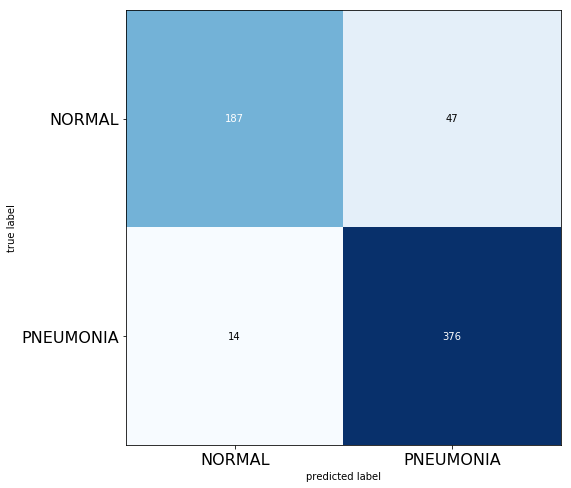

In [11]:
preds = test_model(model,
                   data['test'],
                   labels['test'],
                   batch_size=32)

Loading history from /home/hippolyte/Documents/universite/m1/TER/models/chest_xray/6_vgg19_blocks_fc1/history ...


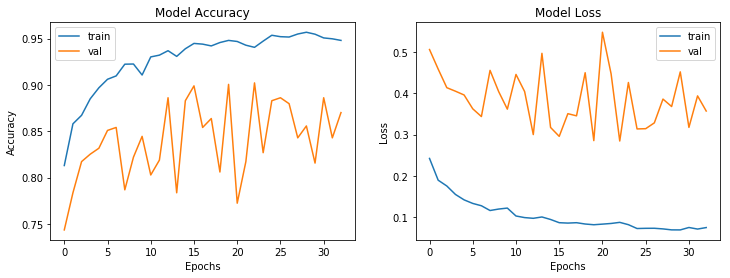

In [15]:
plot_history(CNN_CONFIG_PATH)

# Shap DeepExplainer

True labels are : [[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


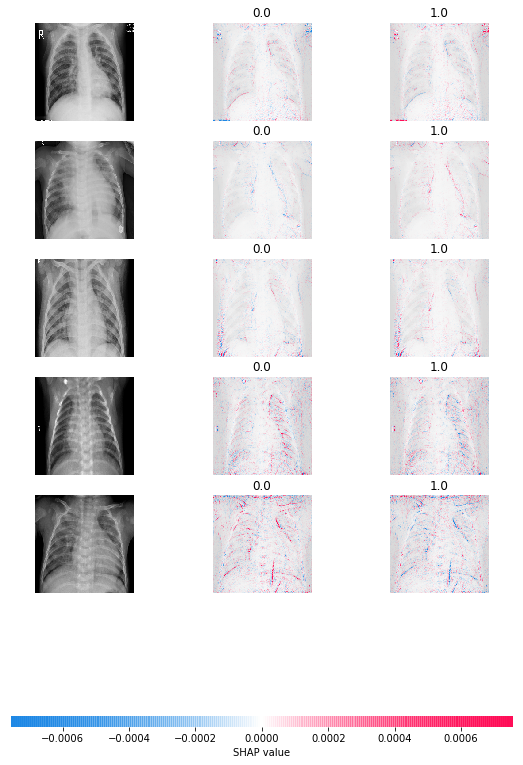

In [16]:
import shap

# syntaxic sugar
train_x = data['train']
test_x = data['test']
test_y = labels['test']

# random indexes
train_indexes = np.random.choice(train_x.shape[0], 10, replace=False)
test_indexes = np.random.choice(test_x.shape[0], 5, replace=False)

# let shap does its job
e = shap.DeepExplainer(model, train_x[train_indexes])
shap_values = e.shap_values(test_x[test_indexes])

# plot the results !
print('True labels are : {}'.format(test_y[test_indexes]))
shap.image_plot(shap_values, test_x[test_indexes], test_y[test_indexes])

# image utility functions

In [158]:
def load_image(path, preprocess=True):
    """Load and preprocess image."""
    x = image.load_img(path, target_size=(HEIGHT, WIDTH))
    if preprocess:
        x = image.img_to_array(x)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
    return x


def deprocess_image(x):
    """Same normalization as in:
    https://github.com/fchollet/keras/blob/master/examples/conv_filter_visualization.py
    """
    x = x.copy()
    if np.ndim(x) > 3:
        x = np.squeeze(x)
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_dim_ordering() == 'th':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x


def normalize(x):
    """Utility function to normalize a tensor by its L2 norm"""
    return (x + 1e-10) / (K.sqrt(K.mean(K.square(x))) + 1e-10)

In [159]:
def build_guided_model():
    """Function returning modified model.
    
    Changes gradient function for all ReLu activations
    according to Guided Backpropagation.
    """
    if "GuidedBackProp" not in ops._gradient_registry._registry:
        @ops.RegisterGradient("GuidedBackProp")
        def _GuidedBackProp(op, grad):
            dtype = op.inputs[0].dtype
            return grad * tf.cast(grad > 0., dtype) * \
                   tf.cast(op.inputs[0] > 0., dtype)

    g = tf.get_default_graph()
    with g.gradient_override_map({'Relu': 'GuidedBackProp'}):
        new_model = return_model(CNN_CONFIG_PATH) #build_model()
    return new_model


def guided_backprop(input_model, images, layer_name):
    """Guided Backpropagation method for visualizing input saliency."""
    input_imgs = input_model.input
    layer_output = input_model.get_layer(layer_name).output
    grads = K.gradients(layer_output, input_imgs)[0]
    backprop_fn = K.function([input_imgs, K.learning_phase()], [grads])
    grads_val = backprop_fn([images, 0])[0]
    return grads_val

In [160]:
def grad_cam(input_model, image, cls, layer_name):
    """GradCAM method for visualizing input saliency."""
    y_c = input_model.output[0, cls]
    conv_output = input_model.get_layer(layer_name).output
    grads = K.gradients(y_c, conv_output)[0]
    # Normalize if necessary
    # grads = normalize(grads)
    gradient_function = K.function([input_model.input], [conv_output, grads])

    output, grads_val = gradient_function([image])
    output, grads_val = output[0, :], grads_val[0, :, :, :]

    weights = np.mean(grads_val, axis=(0, 1))
    cam = np.dot(output, weights)

    # Process CAM
    cam = cv2.resize(cam, (WIDTH, HEIGHT), cv2.INTER_LINEAR)
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()
    return cam

def grad_cam_batch(input_model, images, classes, layer_name):
    """GradCAM method for visualizing input saliency.
    Same as grad_cam but processes multiple images in one run."""
    loss = tf.gather_nd(input_model.output, np.dstack([range(images.shape[0]), classes])[0])
    layer_output = input_model.get_layer(layer_name).output
    grads = K.gradients(loss, layer_output)[0]
    gradient_fn = K.function([input_model.input, K.learning_phase()], [layer_output, grads])

    conv_output, grads_val = gradient_fn([images, 0])    
    weights = np.mean(grads_val, axis=(1, 2))
    cams = np.einsum('ijkl,il->ijk', conv_output, weights)
    
    # Process CAMs
    new_cams = np.empty((images.shape[0], HEIGHT, WIDTH))
    for i in range(new_cams.shape[0]):
        cam_i = cams[i] - cams[i].mean()
        cam_i = (cam_i + 1e-10) / (np.linalg.norm(cam_i, 2) + 1e-10)
        new_cams[i] = cv2.resize(cam_i, (WIDTH, HEIGHT), cv2.INTER_LINEAR)
        new_cams[i] = np.maximum(new_cams[i], 0)
        new_cams[i] = new_cams[i] / new_cams[i].max()
    
    return new_cams

In [182]:
def compute_saliency(model, guided_model, img_path, layer_name='block5_conv3', cls=-1, visualize=True, save=True):
    """Compute saliency using all three approaches.
        -layer_name: layer to compute gradients;
        -cls: class number to localize (-1 for most probable class).
    """
    preprocessed_input = load_image(img_path)

    predictions = model.predict(preprocessed_input)
    #top_n = 5
    #top = decode_predictions(predictions, top=top_n)[0]
    #classes = np.argsort(predictions[0])[-top_n:][::-1]
    #print('Model prediction:')
    #for c, p in zip(classes, top):
    #    print('\t{:15s}\t({})\twith probability {:.3f}'.format(p[1], c, p[2]))
    
    if cls == -1:
        cls = np.argmax(predictions)
    print('Explanation for {}'.format(label_code_to_str(cls)))
    #class_name = decode_predictions(np.eye(1, 1000, cls))[0][0][1]
    #print("Explanation for '{}'".format(class_name))
    
    gradcam = grad_cam(model, preprocessed_input, cls, layer_name)
    gb = guided_backprop(guided_model, preprocessed_input, layer_name)
    guided_gradcam = gb * gradcam[..., np.newaxis]

    if save:
        jetcam = cv2.applyColorMap(np.uint8(255 * gradcam), cv2.COLORMAP_JET)
        jetcam = (np.float32(jetcam) + load_image(img_path, preprocess=False)) / 2
        cv2.imwrite('gradcam.jpg', np.uint8(jetcam))
        cv2.imwrite('guided_backprop.jpg', deprocess_image(gb[0]))
        cv2.imwrite('guided_gradcam.jpg', deprocess_image(guided_gradcam[0]))
    
    if visualize:
        plt.figure(figsize=(15, 10))
        plt.subplot(131)
        plt.title('GradCAM')
        plt.axis('off')
        plt.imshow(load_image(img_path, preprocess=False))
        plt.imshow(gradcam, cmap='jet', alpha=0.5)

        plt.subplot(132)
        plt.title('Guided Backprop')
        plt.axis('off')
        plt.imshow(np.flip(deprocess_image(gb[0]), -1))
        
        plt.subplot(133)
        plt.title('Guided GradCAM')
        plt.axis('off')
        plt.imshow(np.flip(deprocess_image(guided_gradcam[0]), -1))
        plt.show()
        
    return gradcam, gb, guided_gradcam

In [189]:
def compute_saliency_array(model, guided_model, img_array, layer_name='block5_conv3', cls=-1, visualize=True, save=True):
    """Compute saliency using all three approaches.
        -layer_name: layer to compute gradients;
        -cls: class number to localize (-1 for most probable class).
    """
    #preprocessed_input = load_image(img_path)
    preprocessed_input = np.expand_dims(img_array, axis=0)

    predictions = model.predict(preprocessed_input)
    #top_n = 5
    #top = decode_predictions(predictions, top=top_n)[0]
    #classes = np.argsort(predictions[0])[-top_n:][::-1]
    #print('Model prediction:')
    #for c, p in zip(classes, top):
    #    print('\t{:15s}\t({})\twith probability {:.3f}'.format(p[1], c, p[2]))
    
    if cls == -1:
        cls = np.argmax(predictions)
    print('Explanation for {}'.format(label_code_to_str(cls)))
    #class_name = decode_predictions(np.eye(1, 1000, cls))[0][0][1]
    #print("Explanation for '{}'".format(class_name))
    
    gradcam = grad_cam(model, preprocessed_input, cls, layer_name)
    gb = guided_backprop(guided_model, preprocessed_input, layer_name)
    guided_gradcam = gb * gradcam[..., np.newaxis]

    if save:
        jetcam = cv2.applyColorMap(np.uint8(255 * gradcam), cv2.COLORMAP_JET)
        jetcam = (np.float32(jetcam) + load_image(img_path, preprocess=False)) / 2
        cv2.imwrite('gradcam.jpg', np.uint8(jetcam))
        cv2.imwrite('guided_backprop.jpg', deprocess_image(gb[0]))
        cv2.imwrite('guided_gradcam.jpg', deprocess_image(guided_gradcam[0]))
    
    if visualize:
        plt.figure(figsize=(15, 10))
        plt.subplot(131)
        plt.title('GradCAM')
        plt.axis('off')
        plt.imshow(img_array) #load_image(img_path, preprocess=False))
        plt.imshow(gradcam, cmap='jet', alpha=0.5)

        plt.subplot(132)
        plt.title('Guided Backprop')
        plt.axis('off')
        plt.imshow(np.flip(deprocess_image(gb[0]), -1))
        
        plt.subplot(133)
        plt.title('Guided GradCAM')
        plt.axis('off')
        plt.imshow(np.flip(deprocess_image(guided_gradcam[0]), -1))
        plt.show()
        
    return gradcam, gb, guided_gradcam

In [190]:
#model.summary()
guided_model = build_guided_model()

In [200]:
img_test = DATASET_PATH + 'test/PNEUMONIA/person8_virus_27.jpeg'

Explanation for NORMAL


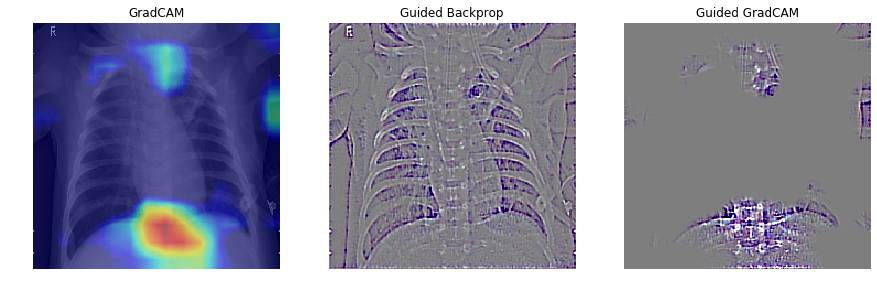

In [201]:
gradcam, gb, guided_gradcam = compute_saliency(model,
                                               guided_model,
                                               img_test,
                                               layer_name='block5_conv4',
                                               cls=-1,
                                               visualize=True,
                                               save=False)

Explanation for PNEUMONIA


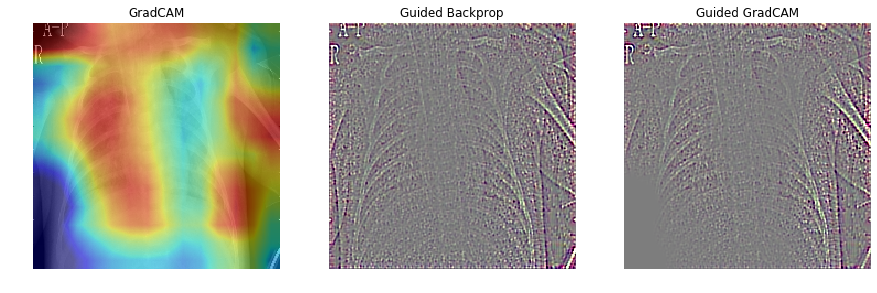

In [205]:
ind = np.random.randint(len(data['val']))
img_test_array = data['val'][ind]

gradcam, gb, guided_gradcam = compute_saliency_array(model,
                                               guided_model,
                                               img_test_array,
                                               layer_name='block5_conv4',
                                               cls=-1,
                                               visualize=True,
                                               save=False)

# multiple images

In [179]:
preds = np.argmax(model.predict(data['val']), 1)
ground_truth = np.argmax(labels['val'], 1)
print('Predicted {} vs Ground Truth {}'.format(preds, ground_truth))

Predicted [0 0 0 0 0 0 0 0 1 1 1 0 1 1 1 1] vs Ground Truth [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]


<function grad_cam at 0x7fbf433bf268>
Predicted 0 vs Ground Truth 0


TypeError: Invalid dimensions for image data

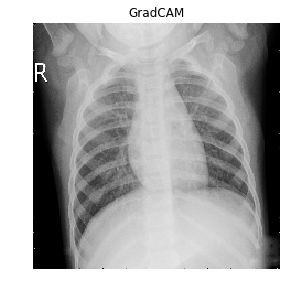

In [199]:
gradcam = np.empty((data['val'].shape[:-1]))
print(grad_cam)

batch_size = 4
for i in range((len(preds) + batch_size -1) // batch_size):
    start = i * batch_size
    end = min((i+1) * batch_size, len(preds))
    gradcam[start:end] = grad_cam_batch(model,
                                        data['val'][start:end],
                                        preds[start:end],
                                        'block5_conv4')

#gradcam.tofile('gradcam.npy')
for i in range(len(preds)):
    print('Predicted {} vs Ground Truth {}'.format(preds[i], ground_truth[i]))
    
    plt.figure(figsize=(15, 10))
    plt.subplot(131)
    plt.title('GradCAM')
    plt.axis('off')
    plt.imshow(data['val'][i]) #load_image(img_path, preprocess=False))
    plt.imshow(gradcam, cmap='jet', alpha=0.5)

    plt.subplot(132)
    plt.title('Guided Backprop')
    plt.axis('off')
    plt.imshow(np.flip(deprocess_image(data['val'][i]), -1))

    plt.subplot(133)
    plt.title('Guided GradCAM')
    plt.axis('off')
    plt.imshow(np.flip(deprocess_image(gradcam[i]), -1))
    plt.show()

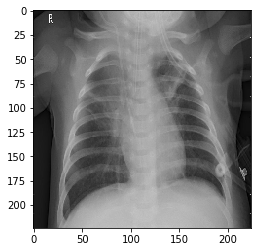

In [137]:
mine = process_image(img_test)
plt.imshow(mine)
plt.show()

his = load_image(img_test)
plt.imshow(his)
plt.show()

mine_ext = np.expand_dims(mine, axis=0)

my_predictions = model.predict(mine_ext)
his_predictions = model.predict(his)
#top_1 = decode_predictions(predictions)[0][0]
print('Predicted class with my func : {} vs {}'.format(my_predictions, his_predictions))
#print('%s (%s) with probability %.2f' % (top_1[1], top_1[0], top_1[2]))